# Error analysis

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
import os
import sys

import lightning as L
import numpy as np
import pandas as pd
import torch
import plotly.express as px
from datasets import load_dataset
from datetime import timedelta
from dotenv import load_dotenv
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import MLFlowLogger
from loguru import logger
from mlflow.models.signature import infer_signature
from pydantic import BaseModel
from torch.utils.data import DataLoader

import mlflow

load_dotenv()

sys.path.insert(0, "..")

from src.dataset import UserItemRatingDFDataset
from src.id_mapper import IDMapper
from src.sequence.inference import SequenceRatingPredictionInferenceWrapper
from src.sequence.model import SequenceRatingPrediction
from src.sequence.trainer import LitSequenceRatingPrediction
from src.sequence.utils import generate_item_sequences
from src.viz import blueq_colors

# Controller

In [5]:
class Args(BaseModel):
    testing: bool = False
    log_to_mlflow: bool = False
    experiment_name: str = "RecSys MVP - Sequence Modeling"
    run_name: str = "002-try-binary"
    notebook_persist_dp: str = None
    random_seed: int = 41
    device: str = None

    batch_size: int = 128

    user_col: str = "user_id"
    item_col: str = "parent_asin"
    rating_col: str = "rating"
    timestamp_col: str = "timestamp"

    top_K: int = 100
    top_k: int = 10

    batch_size: int = 128

    embedding_dim: int = 128
    dropout: float = 0.3
    early_stopping_patience: int = 5
    learning_rate: float = 0.001
    l2_reg: float = 1e-4

    mlf_item2vec_model_name: str = "item2vec"
    mlf_model_name: str = "sequence_rating_prediction"
    min_roc_auc: float = 0.7

    model_path: str = "/Users/dvq/frostmourne/recsys-mvp/notebooks/data/001-seq-model/checkpoints/best-checkpoint-v2.ckpt"

    def init(self):
        self.notebook_persist_dp = os.path.abspath(f"data/{self.run_name}")
        os.makedirs(self.notebook_persist_dp, exist_ok=True)

        if not (mlflow_uri := os.environ.get("MLFLOW_TRACKING_URI")):
            logger.warning(
                f"Environment variable MLFLOW_TRACKING_URI is not set. Setting self.log_to_mlflow to false."
            )
            self.log_to_mlflow = False

        if self.log_to_mlflow:
            logger.info(
                f"Setting up MLflow experiment {self.experiment_name} - run {self.run_name}..."
            )
            self._mlf_logger = MLFlowLogger(
                experiment_name=self.experiment_name,
                run_name=self.run_name,
                tracking_uri=mlflow_uri,
                log_model=True,
            )

        return self


args = Args().init()

print(args.model_dump_json(indent=2))

{
  "testing": false,
  "log_to_mlflow": false,
  "experiment_name": "RecSys MVP - Sequence Modeling",
  "run_name": "001-seq-model",
  "notebook_persist_dp": "/Users/dvq/frostmourne/recsys-mvp/notebooks/data/001-seq-model",
  "random_seed": 41,
  "device": null,
  "batch_size": 128,
  "user_col": "user_id",
  "item_col": "parent_asin",
  "rating_col": "rating",
  "timestamp_col": "timestamp",
  "top_K": 100,
  "top_k": 10,
  "embedding_dim": 128,
  "dropout": 0.3,
  "early_stopping_patience": 5,
  "learning_rate": 0.001,
  "l2_reg": 0.0001,
  "mlf_item2vec_model_name": "item2vec",
  "mlf_model_name": "sequence_rating_prediction",
  "min_roc_auc": 0.7,
  "model_path": "/Users/dvq/frostmourne/recsys-mvp/notebooks/data/001-seq-model/checkpoints/best-checkpoint-v2.ckpt"
}


/Users/dvq/frostmourne/recsys-mvp/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_path" in Args has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# Load model

In [7]:
mlf_client = mlflow.MlflowClient()
model_wrapper = mlflow.pyfunc.load_model(
    model_uri=f"models:/{args.mlf_model_name}@champion"
)
model = model_wrapper.unwrap_python_model().model
idm = model_wrapper.unwrap_python_model().idm

In [8]:
run_id = model_wrapper.metadata.run_id
run_info = mlf_client.get_run(run_id).info
artifact_uri = run_info.artifact_uri

In [9]:
sample_input = mlflow.artifacts.load_dict(f"{artifact_uri}/inferrer/input_example.json")
sample_input

{'user_ids': ['AEZW74DBPW64H5IYA22DX7U7YRIQ'],
 'item_sequences': [['B003UF24SI', 'B004Y3HXXQ']],
 'item_ids': ['B003UF24SI']}

In [10]:
prediction = model_wrapper.predict(sample_input)
prediction

/Users/dvq/frostmourne/recsys-mvp/notebooks/../src/sequence/inference.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  item_sequences = torch.tensor(item_sequences)


{'user_ids': ['AEZW74DBPW64H5IYA22DX7U7YRIQ'],
 'item_sequences': [['B003UF24SI', 'B004Y3HXXQ']],
 'item_ids': ['B003UF24SI'],
 'scores': [0.8486513495445251]}

# Load data

In [118]:
metadata_raw = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Video_Games", trust_remote_code=True
)
metadata_df = (
    metadata_raw["full"].to_pandas()
    .loc[lambda df: df[args.item_col].isin(list(idm.item_to_index.keys()))]
    .assign(
        item_indice=lambda df: df[args.item_col].map(lambda s: idm.get_item_index(s))
    )
)
metadata_df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,item_indice
2,Video Games,NBA 2K17 - Early Tip Off Edition - PlayStation 4,4.3,223,[The #1 rated NBA video game simulation series...,[Following the record-breaking launch of NBA 2...,58.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['NBA 2K17 - Kobe: Haters vs Players...,2K,"[Video Games, PlayStation 4, Games]","{""Release date"": ""September 16, 2016"", ""Best S...",B00Z9TLVK0,None,None,None,763
15,Video Games,"Warhammer 40,000 Dawn of War Game of the Year ...",4.0,68,[Real-time strategy game based on the popular ...,"[From the Manufacturer, This Game of The Year ...",29.95,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",THQ,"[Video Games, PC, Games]","{""Release date"": ""September 20, 2005"", ""Best S...",B001EYUX4Y,None,None,None,532
46,Video Games,Polk Audio Striker Zx Xbox One Gaming Headset ...,3.9,169,[Powered by 40 years of audio heritage and tun...,[Our ProFit Comfort system creates a lightweig...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Polk Audio,"[Video Games, Xbox One, Accessories, Headsets]","{""Release date"": ""October 5, 2014"", ""Best Sell...",B00OLOQGAY,None,None,None,4199
63,Video Games,The Legend of Heroes: Trails in the Sky - Sony...,4.4,91,[After a brief hiatus since its last release i...,"[Product Description, In the peaceful town of ...",185.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['The Legend of Heroes: Trails in th...,Xseed Games,"[Video Games, Legacy Systems, PlayStation Syst...","{""Release date"": ""March 29, 2011"", ""Best Selle...",B004BV5O0U,None,None,None,3554
65,Video Games,Harry Potter: Goblet of Fire - Sony PSP,3.6,38,[All the Magic of the Movie - Characters model...,"[From the Manufacturer, Be Harry Potter in a n...",19.43,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Electronic Arts,"[Purchase Circles, Geography, United States, M...","{""Release date"": ""September 8, 2006"", ""Best Se...",B001ELJEA6,None,None,None,4227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118437,Video Games,Resident Evil 4,4.6,1133,[],[In Resident Evil 4 you'll know a new type of ...,44.98,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Capcom,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""June 19, 2007"", ""Best Seller...",B000P46NKC,None,None,None,622
118457,All Electronics,ivoler Carrying Storage Case for Nintendo Swit...,4.8,13702,[Deluxe Travel Carrying Case. Specially design...,[],26.39,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",ivoler,"[Video Games, Legacy Systems, Nintendo Systems...","{""Product Dimensions"": ""11.2 x 4 x 9 inches"", ...",B076GYVWRY,None,None,None,1268
118459,Video Games,EastVita New Charger Dock + 4 x Battery for Ni...,3.9,676,[Include: 1x Remote Controller Charger 4 x 280...,[Charger Dock + 4 x Battery for Wii Remote],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",EastVita,"[Video Games, Legacy Systems, Nintendo Systems...","{""Pricing"": ""The strikethrough price is the Li...",B004Y2VAVS,None,None,None,2111
118510,Video Games,Mario & Luigi: Partners In Time,4.6,607,"[Players use the top screen to study the land,...",[Mario and Luigi: Partners In Time an insane s...,99.99,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Nintendo,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""November 28, 2005"", ""Best Se...",B000B8J7K0,None,None,None,435


In [36]:
train_df = pd.read_parquet("../data/train_features_neg_df.parquet")
all_val_df = pd.read_parquet("../data/val_features_neg_df.parquet")

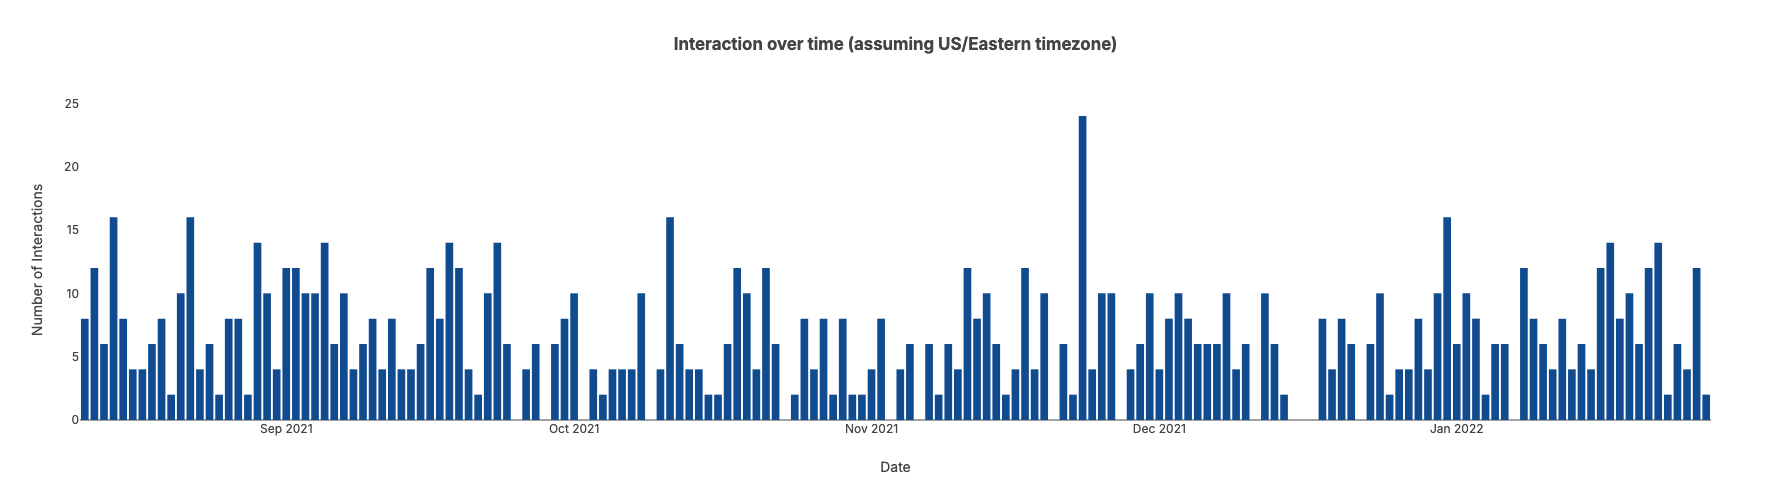

In [39]:
def plot_interaction_over_time(df, timezone="US/Eastern"):
    plot_df = df.assign(
        timestamp_date=df["timestamp"]
        .dt.tz_localize("UTC")
        .dt.tz_convert(timezone)
        .dt.date
    )

    plot_agg_df = plot_df.groupby("timestamp_date").size()

    # Create the plot
    fig = px.bar(
        x=plot_agg_df.index,
        y=plot_agg_df.values,
        labels={"x": "Date", "y": "Number of Interactions"},
        title=f"Interaction over time (assuming {timezone} timezone)",
        height=500,
    )

    fig.update_layout(yaxis=dict(showticklabels=True, tickformat=","))

    fig.show()


timezone = "US/Eastern"  # Assume this time zone because the data is Amazon Data
plot_interaction_over_time(val_df, timezone)

In [37]:
# Split original val into two halfs: val and test
val_days = (val_df[args.timestamp_col].max() - val_df[args.timestamp_col].min()).days // 2
val_max = val_df[args.timestamp_col].min() + timedelta(days=val_days)
val_df = all_val_df.loc[lambda df: df[args.timestamp_col].le(val_max)]
test_df = all_val_df.loc[lambda df: df[args.timestamp_col].gt(val_max)]
assert (val_df.shape[0] + test_df.shape[0]) == all_val_df.shape[0]

In [15]:
user_indices = train_df["user_indice"].unique()
item_indices = train_df["item_indice"].unique()

logger.info(f"{len(user_indices)=:,.0f}, {len(item_indices)=:,.0f}")

2024-10-25 22:44:41.202 | INFO     | __main__:<module>:4 - len(user_indices)=19,578, len(item_indices)=4,630


# Check

In [153]:
def dim_negative(row):
    return ['color: #cccfcd' if row['label'] == 0 else '' for _ in row]

def display_history(df):
    user_df = (
        df
        .loc[lambda df: df['user_indice'].eq(user_indice)]
        .sort_values('timestamp')
    )
    predictions = model.predict(
        torch.tensor(user_df['user_indice'].values),
        torch.tensor(user_df['item_sequence'].values.tolist()),
        torch.tensor(user_df['item_indice'].values),
    ).squeeze().detach().numpy()
    with pd.option_context('display.max_colwidth', None):
        display(
            user_df
            .assign(
                prediction=predictions,
                label=lambda df: df['rating'].gt(0).astype(int)
            )
            [['timestamp', 'item_indice', 'label', 'prediction', 'title', 'main_category', 'categories', 'price', 'description', 'item_sequence']]
            .style.apply(dim_negative, axis=1)
        )

def get_recs(user_indice):
    user_df = train_df.loc[lambda df: df['user_indice'].eq(user_indice)].sort_values('timestamp').iloc[[-1]]
    recs = model.recommend(
        torch.tensor(user_df['user_indice'].values),
        torch.tensor(user_df['item_sequence'].values.tolist()),
        k=10
    )
    recs_df = pd.DataFrame(recs)
    with pd.option_context('display.max_colwidth', None):
        display(
            pd.merge(
                recs_df,
                metadata_df,
                left_on=['recommendation'],
                right_on=['item_indice'],
                how='left'
            )
            [['item_indice', 'score', 'title', 'main_category', 'categories', 'price', 'description']]
        )

In [154]:
user_indice = val_df.sample(1, random_state=1)['user_indice'].iloc[0]

In [155]:
display_history(train_df)

In [156]:
display_history(val_df)

,timestamp,item_indice,label,prediction,title,main_category,categories,price,description,item_sequence
1237,2022-01-13 06:19:05.476000,2214,0,0.936215,Heavy Rain and Beyond Two Souls Collection HD Remastered (Playstation 4 PS4),Video Games,['Video Games' 'PlayStation 4' 'Games'],None,[],[ -1 -1 -1 2285 556 2916 2004 2023 242 484]
1746,2022-01-13 06:19:05.476000,4616,1,0.934653,"PDP Universal PS4/PS5 Media Remote Control, Playstation Gaming Remote Compatible with Sony Playstation 4 and Playstation 5, Bluetooth Detection for up to 4 Devices, TV Power/Input/Volume Controls",Video Games,['Video Games' 'PlayStation 4' 'Accessories' 'Remotes'],None,"['Manage your PS4 systems with this convenient, hassle free remote that lets you control your favorite streaming media through the PS4. The sleek and compact design with improved ergonomics allows you to access all essential controls under one thumb. Keep it simple with this effortless remote. Compatible with the following apps on PS4: Netflix, Amazon, NBA GAME TIME, Blu ray Disc Player, PlayStation Vue, PlayStation Video, Crunchyroll, Funimation, and Media Player.']",[ -1 -1 -1 2285 556 2916 2004 2023 242 484]


In [157]:
get_recs(user_indice)

Generating recommendations:   0%|          | 0/1 [00:00<?, ?it/s]

,item_indice,score,title,main_category,categories,price,description
0,458,0.980676,HTC Vive Deluxe Audio Strap,Video Games,"[Video Games, PC, Virtual Reality, Accessories]",66.64,"[The Vive Deluxe Audio Strap provides integrated earphones with great sound quality so you will have a more convenient VR experience. The earphones offer height and angle adjustment to best fit your ears and are easy to put on and take off as well., Designed for the HTC Vive VR Headset, the HTC Vive Deluxe Audio Strap features an adjustment dial in the back to get the proper fit. Comfort padding and improved weight distribution ensure comfort while wearing the headset during immersive VR gameplay., With integrated on-ear headphones, the HTC Vive Deluxe Audio Strap connects to the Vive VR Headset via a 3.5mm headphone jack. The headphones offer height and angle adjustment to make it easy while putting on and taking off the headset.]"
1,896,0.979494,"NES Classic Controller Extension Cable 3M / 10ft (2-Pack), i-Kawachi SNES Extension Power Cord for Super Nintendo SNES Classic Edition Controller (2017) and Mini NES Classic Edition (2016)",All Electronics,"[Video Games, Legacy Systems, Nintendo Systems, Nintendo NES, Accessories]",12.99,[]
2,1389,0.978927,"Repair Kit for NS Switch, Younik 17 in 1 Switch Screwdriver Set, Screwdriver Game Bit Repair Tool Kit for NS Switch/Switch Lite/J-Con/DS/NES/SNES/DS Lite/GBA",Tools & Home Improvement,"[Video Games, Legacy Systems, Nintendo Systems, Game Boy Systems, Game Boy Color, Accessories]",None,[]
3,3954,0.978782,Microsoft Xbox Wireless Controller - Minecraft Creeper - Xbox One (Discontinued),Video Games,"[Video Games, Xbox One, Accessories, Controllers, Gamepads & Standard Controllers]",None,"[Prepare to create, explore, and survive your own Minecraft adventure with the Minecraft Creeper controller, featuring the iconic green Creeper design, textured grip for enhanced comfort, and ABXY buttons with classic Minecraft font. Enjoy custom button mapping and up to twice the wireless range. Plug in any compatible headset with the 3.5mm stereo headset jack. And with Bluetooth technology, play your favorite games on Windows 10 PCs and tablets.]"
4,3053,0.978522,PowerA MOGA Mobile Gaming Clip for Xbox One Wireless Controllers,Video Games,"[Video Games, Xbox One, Accessories, Controllers, Gamepads & Standard Controllers]",35.87,"[Jump into mobile gaming with this expertly engineered phone clip designed in partnership with the Xbox design studio. Choose from hundreds of games across multiple platforms that are compatible with Bluetooth-enabled Xbox One wireless Controllers. Dual locking articulation points help you reduce fatigue during extended gaming sessions by ergonomically balancing your phone over the controller's center of gravity. The extendable arm secures and protects your phone with rubberized grips and backing pad that fits devices up to 3.12” (79mm) wide. For gaming on the go, the clip easily adjusts down to be compact enough to toss into your bag or pocket. Finally, our 2-year limited warranty reinforces our commitment to quality, ensuring you can trust PowerA products to perform.]"
5,765,0.978166,Nintendo Joy-Con Charging Grip,Video Games,"[Video Games, Nintendo Switch, Accessories, Batteries & Chargers]",None,"[Combine the left and right Joy-Con into one larger controller with this handy grip. It also lets you keep playing while you're charging your Joy-Con, so you don't have to miss a minute.]"
6,681,0.978135,PowerA Charging Stand for Xbox One - White,Video Games,"[Video Games, Xbox One, Accessories, Batteries & Chargers, Chargers]",13.57,"[An Xbox wireless Controller looks great on this charging Stand! The Officially Licensed charging Stand eliminates the cost of replacement batteries. Included are a Universal battery door and rechargeable battery pack, equipped with hours of gameplay for your Xbox wireless Controller or Xbox Elite Wireless Controller. To charge, simply click a Controller down on the char